# Three-Dimensional Lattice Examples

In [1]:
using FreeBird
using Base.Filesystem
using Combinatorics
using CSV
using DataFrames
using Plots
using Profile
# using ProfileView
using Unitful

# Global variables
kB = 8.617333262e-5  # eV/K

8.617333262e-5

In [2]:
function print_lattice_info(lattice::LatticeSystem)
    println("LatticeSystem Information:")
    println("Supercell Dimensions: ", lattice.supercell_dimensions)
    println("Lattice Vectors:")
    println(lattice.lattice_vectors)
    println("Positions:")
    for i in 1:size(lattice.positions, 1)
        println("  Atom $i: (", lattice.positions[i, 1], ", ", lattice.positions[i, 2], ", ", lattice.positions[i, 3], ")")
    end
    println("Occupations: ", lattice.occupations)
    println("Adsorptions: ", lattice.adsorptions)
    println("Neighbors:")
    for i in 1:length(lattice.neighbors)
        first_neighbors, second_neighbors = lattice.neighbors[i]
        println("  Atom $i: First Neighbors - ", first_neighbors, ", Second Neighbors - ", second_neighbors)
    end
end

function plot_lattice(lattice::LatticeSystem)
    x = lattice.positions[:, 1]
    y = lattice.positions[:, 2]
    z = lattice.positions[:, 3]
    
    # Create arrays for colors based on adsorption status
    colors = [if lattice.adsorptions[i] "red" else "blue" end for i in 1:length(x)]
    
    # Create the scatter plot for lattice points with hover labels
    hover_labels = [string("Atom ", i) for i in 1:length(x)]
    p = scatter3d(x, y, z, markersize=5, label="Lattice Points", legend=:topright, hover=hover_labels, color=colors)
    
    # Plot the lattice vectors
    origin = [0.0, 0.0, 0.0]
    a1 = lattice.lattice_vectors[:, 1]
    a2 = lattice.lattice_vectors[:, 2]
    a3 = lattice.lattice_vectors[:, 3]
    
    plot!(p, [origin[1], a1[1]], [origin[2], a1[2]], [origin[3], a1[3]], lw=2, label="a1", color=:red)
    plot!(p, [origin[1], a2[1]], [origin[2], a2[2]], [origin[3], a2[3]], lw=2, label="a2", color=:green)
    plot!(p, [origin[1], a3[1]], [origin[2], a3[2]], [origin[3], a3[3]], lw=2, label="a3", color=:blue)
    
    # Optionally, plot the bonds to neighbors
    for (i, (first_neighbors, second_neighbors)) in enumerate(lattice.neighbors)
        for j in first_neighbors
            plot!(p, [x[i], x[j]], [y[i], y[j]], [z[i], z[j]], lw=1, label="", color=:gray)
        end
        for j in second_neighbors
            plot!(p, [x[i], x[j]], [y[i], y[j]], [z[i], z[j]], lw=1, linestyle=:dash, label="", color=:gray)
        end
    end
    
    display(p)
end

plot_lattice (generic function with 1 method)

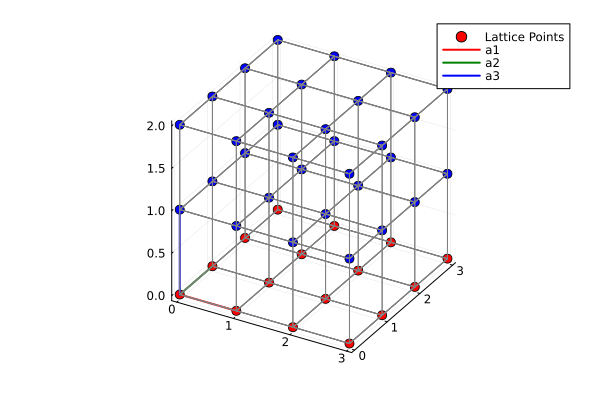

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

In [3]:
# Define a simple cubic lattice
lattice_constant = 1.0
primitive_lattice_vectors = [lattice_constant 0 0; 0 lattice_constant 0; 0 0 lattice_constant]
basis = [(0.0, 0.0, 0.0)]
supercell_dimensions = (4, 4, 3)
periodicity = (true, true, false)
num_total_sites = supercell_dimensions[1]*supercell_dimensions[2]*supercell_dimensions[3]*length(basis)
occupations = [true for i in 1:num_total_sites]
adsorptions = vcat(fill(true, 16), fill(false, num_total_sites - 16))
cutoff_radii = (1.1, 1.1)
lattice = LatticeSystem(primitive_lattice_vectors, basis, supercell_dimensions, periodicity, occupations, adsorptions, cutoff_radii)
# print_lattice_info(lattice)

# plotlyjs()
plot_lattice(lattice)

## Simple Cubic Lattice

In [4]:
# Define parameters for exact enumeration
K = supercell_dimensions[1]
L = supercell_dimensions[2]
M = supercell_dimensions[3]
adsorption_energy = -0.04  # eV
nn_energy = -0.01  # eV
nnn_energy = -0.0025  # eV
cutoff_radii = (1.1, 1.1)
parameters = "simple_cubic_K$(K)_L$(L)_M$(M)_adsorption$(adsorption_energy)_nn$(nn_energy)_nnn$(nnn_energy)_cutoff$(cutoff_radii[1])_$(cutoff_radii[2])"
cv_file = "data/Cv_$parameters.csv"
energies_configs_file = "data/energies_configs_$parameters.csv"

# Ensure the data directory exists
if !isdir("data")
    mkdir("data")
end

# Perform exact enumeration if data files do not exist
if !isfile(cv_file) || !isfile(energies_configs_file)
    df_Cv = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], β = Float64[], T = Float64[], Cv = Float64[])
    df_energies_configs = DataFrame(N = Int[], K = Int[], L = Int[], M = Int[], energy = Float64[], configurations = Any[])

    for N in 1:K
        # Perform exact enumeration
        energies, configurations = exact_enumeration(
            primitive_lattice_vectors,
            basis,
            supercell_dimensions,
            periodicity,
            N,
            adsorptions,
            adsorption_energy,
            nn_energy,
            nnn_energy,
            cutoff_radii
        )

        # Define temperature range and corresponding beta values
        Ts = collect(1.0:0.1:1600.0)  # Temperatures in K
        βs = 1.0 ./ (kB * Ts)  # 1/eV

        # Prepare energy values for Cv calculation
        ωis = ones(length(energies))
        Eis = [ustrip(energy) for energy in energies]
        dof = 0

        # Calculate Cv for each temperature
        Cv_values = [cv(β, ωis, Eis, dof) / kB for β in βs]  # Cv in units of kB

        # Append Cv data to DataFrame
        append!(df_Cv, DataFrame(N = N, K = K, L = L, M = M, β = βs, T = Ts, Cv = Cv_values))

        # Append energy configurations data to DataFrame
        for i in 1:length(energies)
            append!(df_energies_configs, DataFrame(N = N, K = K, L = L, M = M, energy = energies[i], configurations = configurations[i]))
        end
    end

    # Write DataFrames to CSV files
    CSV.write(cv_file, df_Cv)
    CSV.write(energies_configs_file, df_energies_configs)
else
    println("Data files already exist. Skipping exact enumeration.")
end

"data/energies_configs_simple_cubic_K4_L4_M3_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.1.csv"

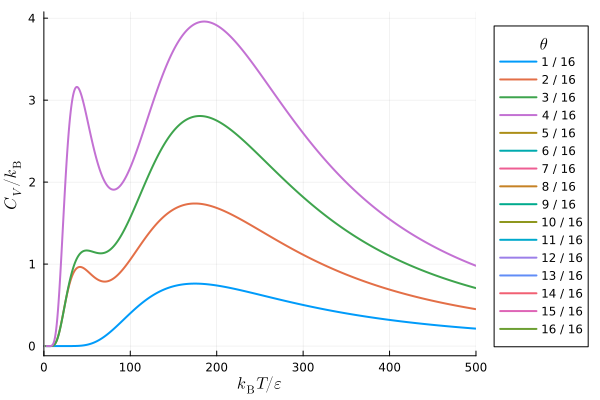

In [9]:
# Read data
Cv = CSV.read("data/Cv_simple_cubic_K4_L4_M3_adsorption-0.04_nn-0.01_nnn-0.0025_cutoff1.1_1.1.csv", DataFrame)

# Create an empty plot with the legend positioned to the right
p = plot(xlabel="\$ k_{\\mathrm{B}} T / ε \$", 
         ylabel="\$ C_V / k_{\\mathrm{B}} \$", 
         size=(600, 400), 
         legendtitle="\$ \\theta \$",
         legend=:outerright)

# Loop over different numbers of occupied sites
for N in 1:K*L*length(basis)
    # Extract the data for the current number of occupied sites
    df_N = filter(row -> row.N == N, copy(Cv))

    # Convert the temperatures to reduced units
    Ts = kB * df_N.T / abs(nn_energy)  # Ensure correct units for T and nn_energy

    # Extract the constant-volume heat capacity data
    Cv_N = df_N.Cv

    # Plot the constant-volume heat capacity as a function of temperature
    # plot!(p, Ts, Cv_N, label="$(N) / $(K * L)", linewidth=2)
    plot!(p, df_N.T, Cv_N, label="$(N) / $(K * L)", linewidth=2, xlim=(0, 500))
end

# Display the plot
display(p)